# Simple CNN architecture and its overview

In [19]:
#import modules
%matplotlib inline

import pylab
import theano
import random
import cPickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lasagne import layers, nonlinearities
from nolearn.lasagne import NeuralNet, BatchIterator, visualize, handlers

In [2]:
# load dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

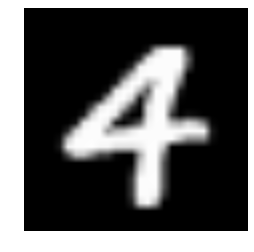

In [3]:
# visualize image
i = random.randrange(0, train.shape[0])

img = np.asarray(train.ix[i, 1:])
img = img.reshape(28, 28)

pylab.imshow(img)
pylab.gray()
pylab.axis('off')
pylab.show()

In [4]:
# preprocess dataset
train_labels = train.ix[:, 0].values.astype(np.int32)
train_images = train.ix[:, 1:].values.astype(np.float32)

train_images /= train_images.std()
train_images -= train_images.mean()

test_images = test.values.astype(np.float32)
test_images /= test_images.std()
test_images -= test_images.mean()

In [5]:
# reshape dataset to fit CNN
X = train_images.reshape(-1, 1, 28, 28)
y = train_labels

test_x = test_images.reshape(-1, 1, 28, 28)

In [6]:
# CNN architecture setup
net = NeuralNet (
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],
    
    input_shape = (None, 1, 28, 28),
    conv1_num_filters = 5, conv1_filter_size = (5, 5),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.4,
    conv2_num_filters = 5, conv2_filter_size = (5, 5),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.4,
    hidden_num_units = 32,
    output_num_units = 10, output_nonlinearity = nonlinearities.softmax,
    
    batch_iterator_train = BatchIterator(batch_size = 150),
    batch_iterator_test = BatchIterator(batch_size = 150),
    
    update_learning_rate = 0.01,
    update_momentum = 0.9,
    
    use_label_encoder = True,
    regression = False,
    max_epochs = 10,
    verbose = 1,
)

In [7]:
# train CNN
net.fit(X, y);

# Neural Network with 3682 learnable parameters

## Layer information

  #  name      size
---  --------  -------
  0  input     1x28x28
  1  conv1     5x24x24
  2  pool1     5x12x12
  3  dropout1  5x12x12
  4  conv2     5x8x8
  5  pool2     5x4x4
  6  dropout2  5x4x4
  7  hidden    32
  8  output    10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       1.94083       0.88238      2.19954      0.74889  18.56s
      2       1.02469       0.44081      2.32454      0.88292  18.78s


/home/faizy/src/lasagne/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [8]:
# test CNN
pred = net.predict(test_x)

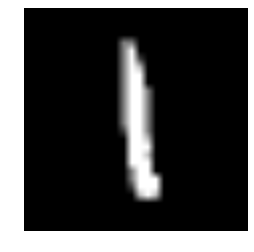

---------------------------
Prediction:  1


In [9]:
# visualize result
i = random.randrange(0, test_x.shape[0])

img = np.asarray(test_x[i])
img = img.reshape(28, 28)

pylab.imshow(img)
pylab.gray()
pylab.axis('off')
pylab.show()
print '---------------------------'
print 'Prediction: ', pred[i]

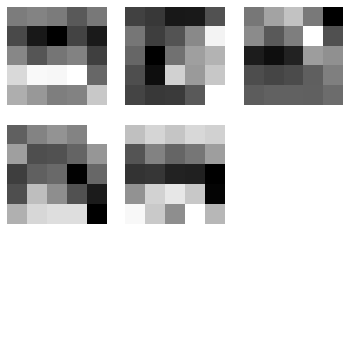

In [14]:
#first layer filters
visualize.plot_conv_weights(net.layers_['conv1'])

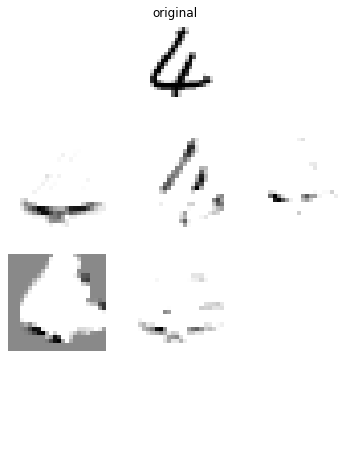

In [15]:
#First Layer output 
visualize.plot_conv_activity(net.layers_['conv1'], test_x[i:i+1, ...])

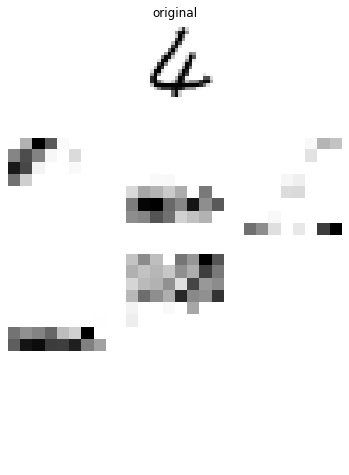

In [16]:
visualize.plot_conv_activity(net.layers_['conv2'], test_x[i:i+1, ...])

In [17]:
dense_layer = layers.get_output(net.layers_['hidden'], deterministic = True)
output_layer = layers.get_output(net.layers_['output'], deterministic = True)
input_var = net.layers_['input'].input_var

f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

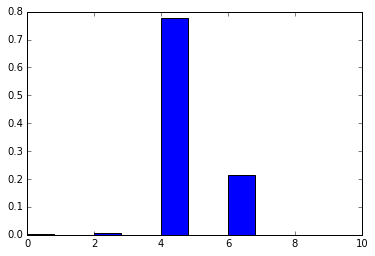

In [18]:
instance = test_x[i][None, ...]
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())
pylab.show()

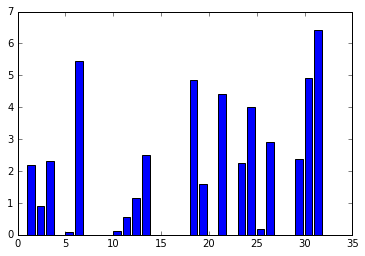

In [19]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())
pylab.show()

In [85]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer. Some classes are given
    default values, all others are calculated pseudorandomly
    from their name.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color.
    :usage:
        >>> color = get_hex_color('MaxPool2DDNN')
        '#9D9DD2'
    """

    if 'Input' in layer_type:
        return '#A2CECE'
    if 'Conv' in layer_type:
        return '#7C9ABB'
    if 'Dense' in layer_type:
        return '#6CCF8D'
    if 'Pool' in layer_type:
        return '#9D9DD2'
    else:
        return '#{0:x}'.format(hash(layer_type) % 2**24)


def get_pydot_graph(layers, output_shape=True, verbose=False):
    """
    Creates a PyDot graph of the network defined by the given layers.
    :parameters:
        - layers : list
            List of the layers, as obtained from lasange.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
        - verbose:
    :returns:
        - pydot_graph : PyDot object containing the graph
    """
    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        key = repr(layer)
        label = layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n' + \
                        '{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\n' + 'nonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\n' + \
                'Output shape: {0}'.format(layer.output_shape)
        pydot_nodes[key] = pydot.Node(key,
                                      label=label,
                                      shape='record',
                                      fillcolor=color,
                                      style='filled',
                                      )

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)
    for edge in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edge[0]], pydot_nodes[edge[1]]))
    return pydot_graph

def draw_to_notebook(layers, **kwargs):
    """
    Draws a network diagram in an IPython notebook
    :parameters:
        - layers : list
            List of the layers, as obtained from lasange.layers.get_all_layers
        - **kwargs: see docstring of get_pydot_graph for other options
    """
    from IPython.display import Image  # needed to render in notebook

    dot = get_pydot_graph(layers, **kwargs)
    return Image(dot.create_png())

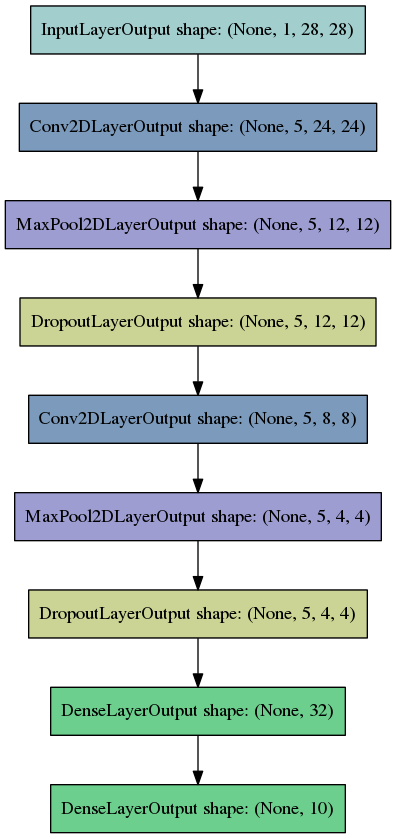

In [97]:
draw_to_notebook(net.get_all_layers())